In [2]:
# from Utills import TrainFX
import json
from requests.exceptions import Timeout
import requests
import requests
from bs4 import BeautifulSoup
import json
import re
from datetime import date, datetime,timedelta
train_info_list = []

max_attempts = 3  # Maximum number of retry attempts

faulty_train = []


In [3]:
class TrainFX():
    def getTrainList(self):
        response = requests.get('http://www.indianrail.gov.in/enquiry/FetchTrainData?_=1557752279434')
        datastore = json.loads(response.text)
        train_numbers = []
        for tr in datastore:
            train_numbers.append(tr.split('-')[0].strip())
        
        print("Found {} trains".format(len(train_numbers)))
        return train_numbers
    
    def getTrainInfo(self, train_number, timeout):
        unix_time = int(datetime.utcnow().timestamp()-1532)
        cookies = {
            '__gads' : 'ID=0b5cc381a6cc5d5e:T=1697635642:RT=1697635642:S=ALNI_MbSIbTJTVGP3rMCM8Xt4aDIub5Evg',
            '_gid' : 'GA1.3.1679543960.1697635644; _ga_SHTZYKNHG2=GS1.1.1697635639.1.1.1697635683.0.0.0',
            'JSESSIONID' : 'GA9C-MwGVJERPBL6MlhhbR39HY-Hq--Fog7TVrg5Lltr7FNiAraG!45373394; _ga=GA1.1.1336431025.1697635639',
        }
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36',
            'Accept': 'application/json, text/plain, */*',
            'Accept-Language': 'en-US,en;q=0.5',
            'Referer': 'https://www.irctc.co.in/nget/booking/check-train-schedule',
            'Content-Type': 'application/x-www-form-urlencoded',
            'greq': str(unix_time),
            'Content-Language': 'en',
            'Connection': 'keep-alive',
        }
        
        response = requests.get('https://www.irctc.co.in/eticketing/protected/mapps1/trnscheduleenquiry/'+train_number, headers=headers, timeout= timeout)
        return response
    
    def getTrainDelay(self, train_number = '', timeout=10):
        unix_time = int(datetime.utcnow().timestamp()-1532)
        cookies = {
            '__gads' : 'ID=0b5cc381a6cc5d5e:T=1697635642:RT=1697635642:S=ALNI_MbSIbTJTVGP3rMCM8Xt4aDIub5Evg',
            '_gid' : 'GA1.3.1679543960.1697635644; _ga_SHTZYKNHG2=GS1.1.1697635639.1.1.1697635683.0.0.0',
            'JSESSIONID' : 'GA9C-MwGVJERPBL6MlhhbR39HY-Hq--Fog7TVrg5Lltr7FNiAraG!45373394; _ga=GA1.1.1336431025.1697635639',
        }
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
            'Accept-Language': 'en-GB,en-US;q=0.9,en;q=0.8',
            # 'Referer': 'https://www.irctc.co.in/nget/booking/check-train-schedule',
            'Content-Type': 'text/html; charset=UTF-8',
            'greq': str(unix_time),
            # 'Content-Language': 'en',
            'Connection': 'keep-alive',
        }
        url = f"https://etrain.info/train/{train_number}/history?d=3"
        response = requests.get(url, headers=headers, timeout= timeout)
        soup = BeautifulSoup(response.content, 'html.parser')
        pattern = re.compile(r'\((.*?)\)')
        section_links = soup.find_all('a', class_='runStatStn')
        section_data = []
        station_delay = {}
        for link in section_links:
            section_name = link.find('div').text.strip()
            avg_delay_text = link.find('div', class_='inlineblock pdl5').text
            avg_delay = int(avg_delay_text.split(':')[1].strip().split(' ')[0])
            section_data.append({'section_name': section_name, 'avg_delay': avg_delay})
            clean_section_name = section_name.replace("\r\n\t\t\t\t\t\t\t\t\nAvg. Delay: ", '')
            station_delay[clean_section_name] = avg_delay

        # for data in section_data:
        #     print(f"Section: {data['section_name']}, Avg. Delay: {data['avg_delay']} Min's")
        station_delay = {pattern.search(key).group(1): value for key, value in station_delay.items()}
        return response, station_delay
    
t = TrainFX()
trainname = t.getTrainList()

Found 5597 trains


### Scrapper call for all train to extract info from IRCTC

In [ ]:

for train in trainname:
    attempts = 0
    while attempts < max_attempts:
        try:
            response = t.getTrainInfo(train, timeout=3)  # Set an appropriate timeout value
            response.raise_for_status()  # Raise an HTTPError for bad responses
            train_info = json.loads(response.text)
            print("Train: ", train, " Info received")
            if 'errorMessage' not in train_info:
                train_info_list.append(train_info)
            else:
                faulty_train.append(train)
                print(f"Faulty train number {train}")
            break  # Break out of the retry loop if successful
        except Timeout as e:
            print(f"Timeout error for train {train}. Retrying... ({attempts + 1}/{max_attempts})")
            attempts += 1
        except requests.RequestException as e:
            print(f"Request failed for train {train} with error: {e}")
            break  # Break out of the loop for other request errors

    if attempts == max_attempts:
        print(f"Error: Max attempts reached for train {train}")

# store the train_info_list in a new file
with open('train_info.json', 'w') as f:
    json.dump(train_info_list, f)




#### Train Delay Scrapping

In [29]:
train_delay_response = t.getTrainDelay('12807')
print(train_delay_response)

{'VSKP': 6, 'SCM': 4, 'VZM': 6, 'VBL': 17, 'PVP': 6, 'PVPT': 5, 'RGDA': 8, 'MNGD': 20, 'AMB': 24, 'KSNG': 31, 'TIG': 32, 'KBJ': 27, 'HSK': 26, 'KRAR': 24, 'BGBR': 24, 'MSMD': 24, 'R': 5, 'DURG': 1, 'RJN': 18, 'DGG': 24, 'G': 30, 'TMR': 34, 'BRD': 38, 'NGP': 31, 'MTY': 46, 'BZU': 51, 'ET': 26, 'BPL': 33, 'BINA': 25, 'LAR': 43, 'VGLJ': 29, 'GWL': 67, 'AGC': 47, 'RKM': 51, 'MTJ': 66, 'FDB': 59, 'NZM': 54}


In [ ]:
train_info = ''
train_with_no_delay_data = []
train_delay_dict = {}
# trainname = trainname[:30]
for train in trainname:
    attempts = 0
    while attempts < max_attempts:
        try:
            response, train_delay = t.getTrainDelay(train, timeout=3)  # Set an appropriate timeout value
            response.raise_for_status()  # Raise an HTTPError for bad responses
            print("Train: ", train, " Info received")
            if 'errorMessage' not in train_info:
                train_delay_dict[train] = train_delay
            else:
                faulty_train.append(train)
                print(f"Faulty train number {train}")
            break  # Break out of the retry loop if successful
        except Timeout as e:
            print(f"Timeout error for train {train}. Retrying... ({attempts + 1}/{max_attempts})")
            attempts += 1
        except requests.RequestException as e:
            train_with_no_delay_data.append(train)
            print(f"Request failed for train {train} with error: {e}")
            break  # Break out of the loop for other request errors

    if attempts == max_attempts:
        print(f"Error: Max attempts reached for train {train}")

# store the train_info_list in a new file
with open('train_average_delay.json', 'w') as f:
    json.dump(train_delay_dict, f)


In [11]:
print(train_with_no_delay_data)

['01047', '07034', '14817', '08501', '07227', '07532', '01080', '59077', '01142', '09471', '16557', '01288', '07405', '03288', '07138', '05557', '07647', '03173', '07478', '01279', '07090', '08305', '05781', '07401', '08624', '03014', '11104', '05552', '54834', '02515', '01059', '01078', '07431', '01585', '03287', '01234', '05887', '02552', '07038', '05531', '06057', '18804', '06437', '09248', '01245', '07180', '07620', '16852', '07648', '08626', '01406', '06175', '04836', '01064', '01262', '09179', '11086', '09445', '02195', '07134', '08478', '22477', '58013', '19336', '02411', '01462', '01110', '59207', '08026', '52587', '19064', '19419', '05119', '02730', '03134', '17203', '02001', '13575', '07183', '08402', '02194', '01007', '06251', '01107', '08616', '11111', '07353', '06553', '09446', '56502', '55663', '02891', '01257', '53050', '02181', '02097', '07571', '09188', '01294', '07048', '08568', '07373', '18191', '03391', '56501', '07253', '55664', '07141', '07473', '01231', '07386', 

### Function to scrape delay for a given train on a given date

In [14]:
def getTrainDelayOnDate(train_no, date, timeout = 4):
    unix_time = int(datetime.utcnow().timestamp()-1532)
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
        'Accept-Language': 'en-GB,en-US;q=0.9,en;q=0.8',
        # 'Referer': 'https://www.irctc.co.in/nget/booking/check-train-schedule',
        'Content-Type': 'text/html; charset=UTF-8',
        'greq': str(unix_time),
        # 'Content-Language': 'en',
        'Connection': 'keep-alive',
    }
    base_url = "https://runningstatus.in/check.php"
    params = {
        'a': 'history',
        'trainno': train_no,
        'duration': 'seldates',
        'fdate': date,
        'tdate': date
    }
    response = requests.get(base_url, params=params, timeout = timeout)
    soup = BeautifulSoup(response.content, 'html.parser')
    delay_table = soup.find('table', class_='table-striped')
    if delay_table is None :
        return response, {}
    date_station_delay = {}
    tds = delay_table.find_all('td', {'class': None, 'style': None})
    stations = tds[::2]  # Select every second td element
    delays = delay_table.find_all('span', class_='text-danger')
    delays = [td.find('span', class_='text-danger') for td in tds[1::2]]

    for station, delay in zip(stations, delays):
        station_name = station.find('abbr').get('title')
        distance = station.find('small').text
        delay_time = delay.text.strip() if delay else ''
        date_station_delay[station_name] = delay_time
    
    return response, date_station_delay

### Function to scrape for all dates in last year for given train number

In [16]:
def getDelayForAllDates(train_no):
    # https://runningstatus.in/check.php?a=history&trainno=12145&duration=seldates&fdate=03-11-2023&tdate=04-11-2023
    
    start_date = date(2022, 11, 1)
    end_date = date(2023, 10, 31)

    current_date = start_date
    train_delay_dict = {}
    while current_date <= end_date:
        formatted_date = current_date.strftime("%d-%m-%Y")
        attempts = 0
        while attempts < max_attempts:
            try:
                response, train_date_dict = getTrainDelayOnDate(train_no, formatted_date)  # Set an appropriate timeout value
                response.raise_for_status()  # Raise an HTTPError for bad responses
                print("Train: ", train_no, " delay for ", formatted_date, " received")
                train_delay_dict[formatted_date] = train_date_dict
                break  # Break out of the retry loop if successful
            except Timeout as e:
                print(f"Timeout error for train {train}. Retrying... ({attempts + 1}/{max_attempts})")
                attempts += 1
            except requests.RequestException as e:
                train_with_no_delay_data.append(train)
                print(f"Request failed for train {train} with error: {e}")
                break  # Break out of the loop for other request errors
            if attempts == max_attempts:
                print(f"Error: Max attempts reached for train {train}")
        
        current_date += timedelta(days=1)
    return train_delay_dict

In [10]:
# Load the JSON file
with open('train_info.json', 'r') as file:
    data = json.load(file)

# Extract values for the key "train number"
train_numbers = [entry.get("trainNumber") for entry in data]

# Print or use the list of train numbers as needed
print(train_numbers)
print(len(train_numbers))

['12303', '17020', '14233', '16232', '22101', '22968', '18628', '22164', '16305', '12822', '14208', '13225', '12740', '11274', '13331', '20658', '12341', '19611', '04121', '16381', '17248', '13404', '12314', '12966', '12709', '22671', '12153', '20632', '12849', '12032', '12735', '17249', '19435', '16606', '05061', '11108', '22852', '22623', '12019', '14614', '12672', '22422', '12787', '18449', '15656', '22867', '17202', '01066', '22967', '13064', '20979', '18636', '17407', '12292', '17226', '12524', '03247', '12834', '16175', '12371', '14054', '12879', '13043', '12369', '18301', '22501', '14717', '22106', '12240', '07255', '22605', '14814', '12266', '07091', '20824', '22724', '12881', '13154', '06142', '22302', '22995', '20704', '12080', '16615', '22199', '20665', '22666', '19271', '17261', '22468', '22679', '19484', '12439', '12594', '08580', '18504', '14316', '15617', '18101', '14865', '15633', '18635', '07411', '12228', '12695', '12965', '22151', '18530', '12567', '12176', '22428', 

In [ ]:
# di, st = getTrainDelayOnDate('15018', '04-10-2023')
# print(st) 
t = getDelayForAllDates('22436')
with open('15018_delay_oneYear.json', 'w') as f:
    json.dump(t, f)

In [ ]:
import numpy as np
final_train_delay_data = {}
num_parts = 20
split_arrays = np.array_split(train_numbers, num_parts)
train_with_no_delay_data = []
for i in range(num_parts):
    train_numbers = split_arrays[i]
    for train in train_numbers:
        t = getDelayForAllDates(train)
        if t == {}:
            train_with_no_delay_data.append(train)
            continue
        final_train_delay_data[train] = t
        with open(f'train_delay_22_23_{i + 1}', 'w') as f:
            json.dump(final_train_delay_data, f)

## Get Average Delay of past 3 months

In [ ]:
# from Utills import TrainFX
import json
from requests.exceptions import Timeout
import requests
import requests
from bs4 import BeautifulSoup
import json
import re
from datetime import date, datetime,timedelta
train_info_list = []

max_attempts = 3  # Maximum number of retry attempts


def getTrainDelay(train_number = '', timeout=10):
    unix_time = int(datetime.utcnow().timestamp()-1532)
    cookies = {
        '__gads' : 'ID=0b5cc381a6cc5d5e:T=1697635642:RT=1697635642:S=ALNI_MbSIbTJTVGP3rMCM8Xt4aDIub5Evg',
        '_gid' : 'GA1.3.1679543960.1697635644; _ga_SHTZYKNHG2=GS1.1.1697635639.1.1.1697635683.0.0.0',
        'JSESSIONID' : 'GA9C-MwGVJERPBL6MlhhbR39HY-Hq--Fog7TVrg5Lltr7FNiAraG!45373394; _ga=GA1.1.1336431025.1697635639',
    }
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
        'Accept-Language': 'en-GB,en-US;q=0.9,en;q=0.8',
        # 'Referer': 'https://www.irctc.co.in/nget/booking/check-train-schedule',
        'Content-Type': 'text/html; charset=UTF-8',
        'greq': str(unix_time),
        # 'Content-Language': 'en',
        'Connection': 'keep-alive',
    }
    url = f"https://etrain.info/train/{train_number}/history?d=3"
    response = requests.get(url, headers=headers, timeout= timeout)
    soup = BeautifulSoup(response.content, 'html.parser')
    pattern = re.compile(r'\((.*?)\)')
    section_links = soup.find_all('a', class_='runStatStn')
    section_data = []
    station_delay = {}
    for link in section_links:
        section_name = link.find('div').text.strip()
        avg_delay_text = link.find('div', class_='inlineblock pdl5').text
        avg_delay = int(avg_delay_text.split(':')[1].strip().split(' ')[0])
        section_data.append({'section_name': section_name, 'avg_delay': avg_delay})
        clean_section_name = section_name.replace("\r\n\t\t\t\t\t\t\t\t\nAvg. Delay: ", '')
        station_delay[clean_section_name] = avg_delay

    # for data in section_data:
    #     print(f"Section: {data['section_name']}, Avg. Delay: {data['avg_delay']} Min's")
    station_delay = {pattern.search(key).group(1): value for key, value in station_delay.items()}
    return response, station_delay


train_info = ''
train_with_no_delay_data = []
train_delay_dict = {}


with open('train_info.json', 'r') as file:
    data = json.load(file)
train_numbers = [entry.get("trainNumber") for entry in data]

print(train_numbers)
for train in train_numbers:
    attempts = 0
    while attempts < max_attempts:
        try:
            response, train_delay = getTrainDelay(train, timeout=3)  # Set an appropriate timeout value
            response.raise_for_status()  # Raise an HTTPError for bad responses
            if 'errorMessage' not in train_info:
                print("Train: ", train, " Info received")
                train_delay_dict[train] = train_delay
            else:
                print(f"Faulty train number {train}")
            break  # Break out of the retry loop if successful
        except Timeout as e:
            print(f"Timeout error for train {train}. Retrying... ({attempts + 1}/{max_attempts})")
            attempts += 1
        except requests.RequestException as e:
            train_with_no_delay_data.append(train)
            print(f"Request failed for train {train} with error: {e}")
            break  # Break out of the loop for other request errors

    if attempts == max_attempts:
        print(f"Error: Max attempts reached for train {train}")

# store the train_info_list in a new file
with open('train_average_delay.json', 'w') as f:
    json.dump(train_delay_dict, f)


### Analysis on average delay 

In [22]:
station_delay_sum = {}
station_delay_count = {}

with open('train_average_delay.json', 'r') as file:
    data = json.load(file)

for train in data:
    for station in data[train]:
        if station in station_delay_sum:
            station_delay_sum[station] += max(0, data[train][station])
            station_delay_count[station] += 1
        else:
            station_delay_sum[station] = max(0, data[train][station])
            station_delay_count[station] = 1



### Highest Average delay station

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

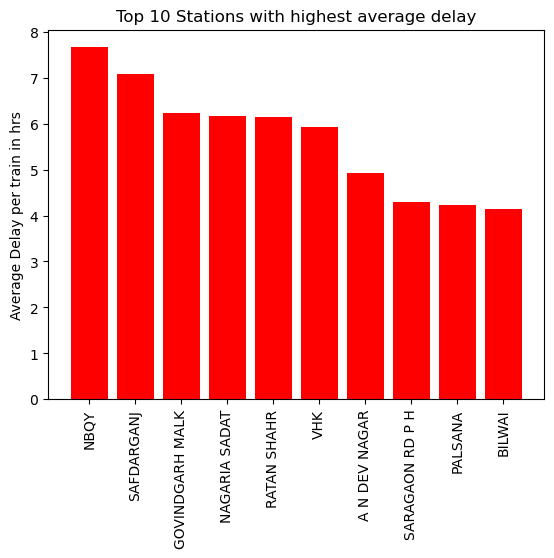

In [26]:
# visualise via bar graph the average delay at each station for top 10 stations
station_delay_avg = {station: station_delay_sum[station]/station_delay_count[station] for station in station_delay_sum}
station_delay_avg = {k: v for k, v in sorted(station_delay_avg.items(), key=lambda item: item[1], reverse=True)}

with open('station_code_name.json', 'r') as f:
    mapping = json.load(f)

import matplotlib.pyplot as plt
import numpy as np
# visualise via bar graph the average delay at each station for top 10 stations
station = list(station_delay_avg.keys())[:10]
station = [mapping[station] if station in mapping else station for station in station]
delay = list(station_delay_avg.values())[:10]
delay = [d/60 for d in delay]
# plot station vs delay in bar graph
plt.bar(station, delay)
# include a title
plt.title('Top 10 Stations with highest average delay')
# include a label for y-axis
plt.ylabel('Average Delay per train in hrs')
# change colour of bar to red
plt.bar(station, delay, color='red')
# beautify the bar
plt.xticks(rotation=90)

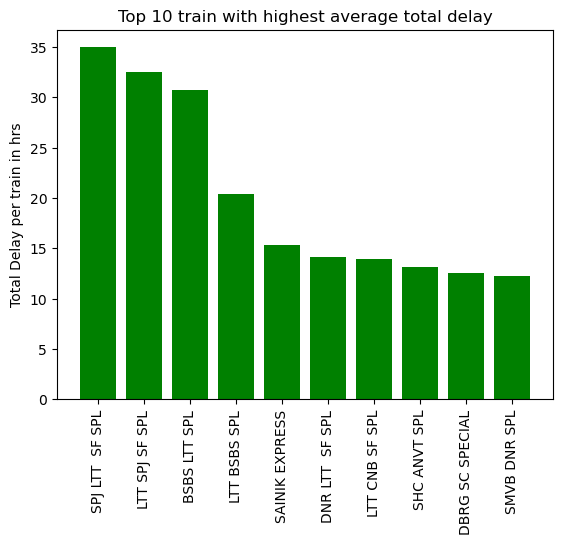

In [23]:
import json
import ast
train_delay = {}
with open('train_average_delay.json', 'r') as file:
    data = json.load(file)

with open('train_info.json', 'r') as file:
    data2 = json.load(file)

train_number_name_dict = {}
station_code_name_dict = {}

for entry in data2:
    train_number_name_dict[entry.get('trainNumber')] = entry.get('trainName')
    stationlist = entry.get('stationList')
    if(stationlist == None):
        continue
    for station in stationlist:
        if(station.get('stationCode')  not in station_code_name_dict):
            station_code_name_dict[station.get('stationCode')] = station.get('stationName')

with open('train_number_name.json', 'w') as file:
    json.dump( train_number_name_dict, file)

with open('station_code_name.json', 'w') as file:
    json.dump( station_code_name_dict, file)
    
# print(train_number_name_dict)
for train in data:
    x = 0
    if(len(data[train]) == 0):
        continue
    for station in data[train]:
        x += data[train][station]
    train_delay[train] = x/len(data[train])

train_delay = {k: v for k, v in sorted(train_delay.items(), key=lambda item: item[1], reverse=True)}


import matplotlib.pyplot as plt
import numpy as np

train = list(train_delay.keys())[:10]
delay = list(train_delay.values())[:10]

train = [train_number_name_dict[t] for t in train]
delay = [d/60 for d in delay]

plt.bar(train, delay)
plt.title('Top 10 train with highest average total delay')
plt.ylabel('Total Delay per train in hrs')
plt.bar(train, delay, color='green')
y = plt.xticks(rotation=90)